In [ ]:
#  Imports & config 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import gpflow as gf
from sklearn.preprocessing import StandardScaler

import preprocessing as prep
import kernels as gkern
import inducing_variables as gind
import training as gtrain  
import utils               

# GPU config 
print("GPUs:", tf.config.list_physical_devices("GPU"))
for g in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(g, True)

gf.config.set_default_float(tf.float64)
tf_float = gf.config.default_float()
np_float = tf.as_dtype(tf_float).as_numpy_dtype


GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import numpy as np
import pandas as pd

LOOKBACK = 60

H = 40

TRAIN_FRAC = 0.70
VAL_FRAC   = 0.15  

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import re

df = pd.read_csv("aluminium_raw_inputs.csv", parse_dates=['date']).sort_values('date')

# core signals (daily)
df["log_returns"] = np.log(df["al_lme_prices"] / df["al_lme_prices"].shift(1))
df = df.dropna()

# realized 30d volatility (annualized) and logs
df["vol"]      = df["log_returns"].rolling(window=30).std() * np.sqrt(252)
df["log_vol"]  = np.log(df["vol"] + 1e-12)

# targets (NEXT 30d realized vol)
df["target_vol"]     = df["vol"].shift(-H)
df["target_log_vol"] = np.log(df["target_vol"] + 1e-12)

# sign-aware shocks & leverage 
r = df["log_returns"].astype(float)
df["abs_r"]   = r.abs()
df["sq_r"]    = r**2
df["sign_r"]  = np.sign(r).replace({0.0: 0.0})
df["lev"]     = df["sign_r"] * df["sq_r"]      

# downside / upside semivariances (weekly & monthly)
for k in [5, 22]:
    neg = (r < 0).astype(float)
    pos = (r > 0).astype(float)
    df[f"rs_neg_{k}"] = (df["sq_r"] * neg).rolling(k).mean()
    df[f"rs_pos_{k}"] = (df["sq_r"] * pos).rolling(k).mean()

# HAR-style realized vol logs
for k in [1, 5, 22]:
    df[f"har_logrv_{k}"] = np.log(df["sq_r"].rolling(k).mean() * 252 + 1e-12)

# classic lagged log-vol 
df["lag1_log_vol"]   = df["log_vol"].shift(1)
df["lag7_log_vol"]   = df["log_vol"].shift(7)
df["lag30_log_vol"]  = df["log_vol"].shift(30)

df = df.dropna().reset_index(drop=True)

print(df[["date","log_returns","vol","target_vol"]].head(3))
print(df[["date","log_returns","vol","target_vol"]].tail(3))


        date  log_returns       vol  target_vol
0 2016-04-08     0.012886  0.158188    0.160807
1 2016-04-11    -0.005837  0.153134    0.162024
2 2016-04-12     0.019051  0.164589    0.164153
           date  log_returns       vol  target_vol
2343 2025-04-02    -0.008670  0.137598    0.194270
2344 2025-04-03    -0.018449  0.135494    0.195644
2345 2025-04-04    -0.031237  0.152933    0.196028


In [ ]:

T = len(df)
all_t = list(range(LOOKBACK, T))

n_total = len(all_t)
n_tr = int(np.floor(n_total * TRAIN_FRAC))
n_va = int(np.floor(n_total * VAL_FRAC))
n_te = n_total - n_tr - n_va
assert n_tr > 0 and n_va > 0 and n_te > 0, "Dataset too small for the chosen splits/LOOKBACK."

idx_tr_win = list(range(0, n_tr))
idx_va_win = list(range(n_tr, n_tr + n_va))
idx_te_win = list(range(n_tr + n_va, n_total))

cutoff_row = LOOKBACK + idx_tr_win[-1] + 1

#PCA
def _extract_category(colname: str):
    m = re.match(r"\('FeatureName\.([A-Za-z0-9_]+)'\s*,", str(colname))
    return m.group(1) if m else None

cand_cols = [
    "log_returns","abs_r","sq_r","sign_r","lev",
    "rs_neg_5","rs_pos_5","rs_neg_22","rs_pos_22",
    "har_logrv_1","har_logrv_5","har_logrv_22",
    "log_vol","lag1_log_vol","lag7_log_vol","lag30_log_vol","garch30_logvol_feat"
]

categories = {}
for c in df.columns:
    cat = _extract_category(c)
    if cat:
        categories.setdefault(cat, []).append(c)

# ---------- config ----------
MIN_CAT_COLS        = 2      # need at least 2 raw cols to run PCA
MIN_TRAIN_ROWS      = 50     # require enough rows after dropna
MAX_PCS_CONSIDER    = 6      # safety cap per category (first N PCs to try)
PCVOL_WINDOWS       = [5, 22, 30]    # horizons in days
PCVOL_CORR_THR      = 0.20   # keep only PC-vol features with |corr_train| >= 0.20

kept_pcvol_names = []

train_slice = slice(0, cutoff_row)

for cat, cols in categories.items():
    cols = [c for c in cols if c in df.columns]
    if len(cols) < MIN_CAT_COLS:
        continue

    train_sub = df.loc[train_slice, cols + ["target_log_vol"]].dropna()
    if train_sub.shape[0] < MIN_TRAIN_ROWS:
        continue

    X_tr_p = train_sub[cols].to_numpy(dtype=np.float64)
    y_tr_p = train_sub["target_log_vol"].to_numpy(dtype=np.float64)
    scaler_p = StandardScaler().fit(X_tr_p)
    Xs_tr_p  = scaler_p.transform(X_tr_p)
    pca      = PCA().fit(Xs_tr_p)

    train_means_p = df.loc[train_slice, cols].mean(skipna=True)
    X_full      = df[cols].fillna(train_means_p).to_numpy(dtype=np.float64)
    comps_full  = pca.transform(scaler_p.transform(X_full))   # shape (T, p)

    p = min(comps_full.shape[1], MAX_PCS_CONSIDER)
    pc_names_this_cat = []
    tmp_feat_df = {}

    for j in range(p):
        pc_col_name = f"{cat}_PC{j+1}"
        pc_series   = pd.Series(comps_full[:, j], index=df.index, name=pc_col_name)
        dpc = pc_series.diff()

        for k in PCVOL_WINDOWS:
            feat_name = f"{pc_col_name}_vol{k}"
            tmp_feat_df[feat_name] = np.log(dpc.rolling(k).std() * np.sqrt(252.0) + 1e-12)
            pc_names_this_cat.append(feat_name)

    if not pc_names_this_cat:
        continue

    eval_cols = ["target_log_vol"] + pc_names_this_cat
    eval_frame = pd.concat([df[["target_log_vol"]],
                            pd.DataFrame(tmp_feat_df, index=df.index)], axis=1)

    sub_train = eval_frame.loc[train_slice, eval_cols].dropna()
    if sub_train.shape[0] < 5:
        continue

    corr_train_vec = sub_train.corr(numeric_only=True)["target_log_vol"].drop("target_log_vol", errors="ignore")
    kept_feats = [f for f in pc_names_this_cat if abs(float(corr_train_vec.get(f, np.nan))) >= PCVOL_CORR_THR]

    for f in kept_feats:
        df[f] = eval_frame[f]
        kept_pcvol_names.append(f)
        cand_cols.append(f)

if kept_pcvol_names:
    print(f"Added {len(kept_pcvol_names)} PC rolling-vol features with |corr_train| ≥ {PCVOL_CORR_THR}:")
    print(", ".join(kept_pcvol_names[:min(12, len(kept_pcvol_names))]) + (" ..." if len(kept_pcvol_names) > 12 else ""))
else:
    print("No PC rolling-vol features met the |corr_train| threshold; none added.")



Added 23 PC rolling-vol features with |corr_train| ≥ 0.2:
IMPORT_CURRENCY_PC2_vol22, IMPORT_CURRENCY_PC2_vol30, IMPORT_CURRENCY_PC3_vol5, IMPORT_CURRENCY_PC3_vol22, IMPORT_CURRENCY_PC3_vol30, IMPORT_CURRENCY_PC4_vol22, IMPORT_CURRENCY_PC4_vol30, IMPORT_CURRENCY_PC6_vol22, IMPORT_CURRENCY_PC6_vol30, SENTIMENT_PC1_vol5, SENTIMENT_PC1_vol22, SENTIMENT_PC1_vol30 ...


In [ ]:
# GARCH(1,1) feature
from arch import arch_model

def build_garch30_log_feature_full_series(df: pd.DataFrame, cutoff_row: int, H: int = 30) -> np.ndarray:
    """
    Fit GARCH(1,1) on returns[:cutoff_row], then compute a 30d mean-variance
    forecast at *every* origin j (using r_j and σ_j^2), storing the annualized
    log-vol at index j. No leading NaNs; safe for all windows.
    """
    returns = df["log_returns"].to_numpy(dtype=float)
    T = len(returns)

    garch30_log_feat = np.empty(T, dtype=float); garch30_log_feat[:] = np.nan
    sigma2_filt = np.empty(T, dtype=float);      sigma2_filt[:] = np.nan

    train_returns = returns[:cutoff_row]
    if train_returns.size < 100:
        print(f"[GARCH] Too few train obs ({train_returns.size}) — using EWMA fallback.")
        lam = 0.94
        sigma2_filt[0] = np.var(train_returns) if train_returns.size > 1 else np.var(returns[:max(2, cutoff_row+1)])
        for t in range(1, cutoff_row):
            sigma2_filt[t] = lam * sigma2_filt[t-1] + (1-lam) * (returns[t-1]**2)
        for t in range(cutoff_row, T):
            sigma2_filt[t] = lam * sigma2_filt[t-1] + (1-lam) * (returns[t-1]**2)
        omega = (1-lam) * np.mean(train_returns**2)
        alpha = 1 - lam
        beta  = lam
        phi   = alpha + beta
    else:
        try:
            am  = arch_model(train_returns, mean="Zero", vol="Garch", p=1, q=1, dist="normal")
            res = am.fit(disp="off")

            omega = float(res.params["omega"])
            alpha = float(res.params["alpha[1]"])
            beta  = float(res.params["beta[1]"])
            phi   = alpha + beta

            if not np.isfinite(phi) or phi >= 0.999:
                phi = 0.999
                unconditional = np.var(train_returns)
                omega = unconditional * (1 - phi)

            sig_train = np.asarray(res.conditional_volatility, dtype=float)  # σ_t
            sigma2_filt[:cutoff_row] = sig_train**2

            for t in range(cutoff_row, T):
                sigma2_filt[t] = omega + alpha * (returns[t-1]**2) + beta * sigma2_filt[t-1]
        except Exception as e:
            print(f"[GARCH] Fit failed ({e}) — using EWMA fallback.")
            lam = 0.94
            sigma2_filt[0] = np.var(train_returns) if train_returns.size > 1 else np.var(returns[:max(2, cutoff_row+1)])
            for t in range(1, cutoff_row):
                sigma2_filt[t] = lam * sigma2_filt[t-1] + (1-lam) * (returns[t-1]**2)
            for t in range(cutoff_row, T):
                sigma2_filt[t] = lam * sigma2_filt[t-1] + (1-lam) * (returns[t-1]**2)
            omega = (1-lam) * np.mean(train_returns**2)
            alpha = 1 - lam
            beta  = lam
            phi   = alpha + beta

    for j in range(T):
        sigma2_1 = omega + alpha * (returns[j] ** 2) + beta * sigma2_filt[j]
        s = 0.0
        sigma2_h = sigma2_1
        for _ in range(H):
            s += sigma2_h
            sigma2_h = omega + phi * sigma2_h
        var_win = s / H
        vol_win = np.sqrt(var_win) * np.sqrt(252.0)
        garch30_log_feat[j] = np.log(vol_win + 1e-8)

    return garch30_log_feat

df["garch30_logvol_feat"] = build_garch30_log_feature_full_series(df, cutoff_row, H=H)
if "garch30_logvol_feat" not in cand_cols:
    cand_cols.append("garch30_logvol_feat")

df_base = df[["date"] + cand_cols + ["target_log_vol"]].copy()
df_base["al_lme_prices"] = df["al_lme_prices"]  # ensure present

corr_train = (
    df_base.iloc[:cutoff_row]
          .drop(columns=["date"])
          .corr()["target_log_vol"]
          .abs()
          .sort_values(ascending=False)
)

thr = 0.1
keep = [c for c in cand_cols if c in corr_train.index and corr_train[c] >= thr]
if not keep:
    keep = ["log_vol","lag1_log_vol","har_logrv_5","har_logrv_22","abs_r","sq_r","lev","garch30_logvol_feat","al_lme_prices","log_returns"]
else:
    # guarantee these are present for downstream plotting/diagnostics
    for mandatory in ["al_lme_prices","log_returns"]:
        if mandatory not in keep:
            keep.append(mandatory)

print(f"Selected {len(keep)} features (|corr| ≥ {thr:.2f}):", keep)



Selected 38 features (|corr| ≥ 0.10): ['abs_r', 'sq_r', 'rs_neg_5', 'rs_pos_5', 'rs_neg_22', 'rs_pos_22', 'har_logrv_5', 'har_logrv_22', 'log_vol', 'lag1_log_vol', 'lag7_log_vol', 'lag30_log_vol', 'garch30_logvol_feat', 'IMPORT_CURRENCY_PC2_vol22', 'IMPORT_CURRENCY_PC2_vol30', 'IMPORT_CURRENCY_PC3_vol5', 'IMPORT_CURRENCY_PC3_vol22', 'IMPORT_CURRENCY_PC3_vol30', 'IMPORT_CURRENCY_PC4_vol22', 'IMPORT_CURRENCY_PC4_vol30', 'IMPORT_CURRENCY_PC6_vol22', 'IMPORT_CURRENCY_PC6_vol30', 'SENTIMENT_PC1_vol5', 'SENTIMENT_PC1_vol22', 'SENTIMENT_PC1_vol30', 'SENTIMENT_PC2_vol22', 'SENTIMENT_PC2_vol30', 'SENTIMENT_PC3_vol22', 'SENTIMENT_PC3_vol30', 'SENTIMENT_PC4_vol22', 'SENTIMENT_PC4_vol30', 'SENTIMENT_PC5_vol22', 'SENTIMENT_PC5_vol30', 'SENTIMENT_PC6_vol5', 'SENTIMENT_PC6_vol22', 'SENTIMENT_PC6_vol30', 'al_lme_prices', 'log_returns']


/cs/student/projects1/dsml/2024/eborso/project_venv/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000167. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [ ]:
X_list, y_list = [], []

train_means_F = df_base.loc[:cutoff_row-1, keep].mean(numeric_only=True)
F_df = df_base[keep].copy()
F_df = F_df.fillna(train_means_F)  

F   = F_df.to_numpy(dtype=np.float64)
y_l = df_base["target_log_vol"].to_numpy(dtype=np.float64)

for t in all_t:
    x_win = F[t-LOOKBACK:t, :]  
    X_list.append(x_win)
    y_list.append(y_l[t])        

X_list = prep.add_time_to_list(X_list)
y = np.asarray(y_list, dtype=np.float64)

X_tr_list = [X_list[i] for i in idx_tr_win]
X_va_list = [X_list[i] for i in idx_va_win]
X_te_list = [X_list[i] for i in idx_te_win]
y_tr_log  = y[idx_tr_win]
y_va_log  = y[idx_va_win]
y_te_log  = y[idx_te_win]

# scaling
from sklearn.preprocessing import StandardScaler
time_is_first = False

if time_is_first:
    def scale_list(lst, scaler=None):
        outs, scal = [], scaler
        for x in lst:
            tcol = x[:, :1]
            fcol = x[:, 1:]
            if scal is None:
                scal = StandardScaler().fit(fcol)
            outs.append(np.concatenate([tcol, scal.transform(fcol)], axis=1))
        return outs, scal

    X_tr_list, scaler_X = scale_list(X_tr_list, scaler=None)
    X_va_list, _        = scale_list(X_va_list, scaler_X)
    X_te_list, _        = scale_list(X_te_list, scaler_X)
else:
    stack_tr = np.concatenate(X_tr_list, axis=0)
    scaler_X = StandardScaler().fit(stack_tr)
    X_tr_list = [scaler_X.transform(x) for x in X_tr_list]
    X_va_list = [scaler_X.transform(x) for x in X_va_list]
    X_te_list = [scaler_X.transform(x) for x in X_te_list]

X_tr = prep.tabulate_list_of_sequences(X_tr_list)
X_va = prep.tabulate_list_of_sequences(X_va_list)
X_te = prep.tabulate_list_of_sequences(X_te_list)

scaler_y = StandardScaler().fit(y_tr_log.reshape(-1,1))
y_tr = scaler_y.transform(y_tr_log.reshape(-1,1)).ravel()
y_va = scaler_y.transform(y_va_log.reshape(-1,1)).ravel()
y_te = scaler_y.transform(y_te_log.reshape(-1,1)).ravel()

print("Shapes — X_tr", X_tr.shape, "X_va", X_va.shape, "X_te", X_te.shape)
print("Done. Use X_tr/X_va/X_te and y_tr/y_va/y_te in your GP.")


100%|██████████| 344/344 [00:00<00:00, 3309267.38it/s]

Shapes — X_tr (1600, 60, 39) X_va (342, 60, 39) X_te (344, 60, 39)
Done. Use X_tr/X_va/X_te and y_tr/y_va/y_te in your GP.


In [ ]:
# Model: kernel, inducing, mean 
num_train, L, d = X_tr.shape
input_dim    = L * d
num_levels   = 3
num_lags     = 0
num_inducing = min(200, num_train)

# Inducing init
try:
    Z_init = utils.suggest_initial_inducing_tensors_tf2(
        X_tr, num_levels, num_inducing, increments=False, num_lags=num_lags
    )
except Exception:
    sel = np.random.RandomState(0).choice(len(X_tr), size=num_inducing, replace=False)
    Z_init = X_tr[sel]

feat = gind.InducingTensors(Z_init, num_levels=num_levels, increments=False)

# Lengthscale init 
try:
    l_init = utils.suggest_initial_lengthscales(X_tr, num_samples=1000)
except Exception:
    l_init = np.ones(d, dtype=np_float)

k = gkern.SignatureMix(
    input_dim=input_dim,
    num_features=d,
    num_levels=num_levels,
    lengthscales=l_init,
    difference=True
)

lik = gf.likelihoods.Gaussian()

from gpflow import mean_functions as mf

class SequenceConstant(mf.MeanFunction):
    """Trainable scalar c; returns (N,1) regardless of input rank."""
    def __init__(self, init=0.0):
        super().__init__()
        self.c = tf.Variable([[np_float(init)]], dtype=tf_float, trainable=True)  # shape (1,1)

    def __call__(self, X):
        X = tf.convert_to_tensor(X, dtype=tf_float)
        N = tf.shape(X)[0]
        return tf.tile(self.c, [N, 1])  # (N,1)

seq_const_mean = SequenceConstant(init=0.0)


import models
model = models.SVGPForSignatures(
    kernel=k,
    likelihood=lik,
    inducing_variable=feat,
    num_latent_gps=1,
    whiten=True,
    q_diag=True,
    mean_function=seq_const_mean,
)



In [ ]:
BATCH = 128
train_ds = (
    tf.data.Dataset
      .from_tensor_slices((X_tr.astype(np_float), y_tr.reshape(-1,1).astype(np_float)))
      .shuffle(len(X_tr))
      .repeat()                      
      .batch(BATCH)
      .prefetch(tf.data.AUTOTUNE)
)
train_it = iter(train_ds)

model.num_data = int(X_tr.shape[0])

loss_closure = model.training_loss_closure(train_it, compile=True)

In [ ]:
PRED_CHUNK = 128

def _to_tf3(X_seq):
    return tf.convert_to_tensor(X_seq, dtype=tf_float)

def _pred_scaled_batched(m, X_seq, chunk=PRED_CHUNK):
    """
    Predict mean/var in the SAME scaled log space used for training (y ~ N(mu, var)).
    Returns arrays shaped (N,).
    """
    N = len(X_seq)
    mu_parts, var_parts = [], []
    noise = float(m.likelihood.variance.numpy())
    for i in range(0, N, chunk):
        xb = _to_tf3(X_seq[i:i+chunk])
        f_mu, f_var = m.predict_f(xb)                 # (B,1), (B,1)
        y_mu  = tf.reshape(f_mu,  [-1]).numpy()
        y_var = tf.reshape(f_var, [-1]).numpy() + noise
        y_var = np.maximum(y_var, 1e-12)
        mu_parts.append(y_mu); var_parts.append(y_var)
    return np.concatenate(mu_parts), np.concatenate(var_parts)

def _unscale_log(mu_scaled, var_scaled):
    """
    Convert (mu, var) from scaled log space to unscaled log units.
    """
    mu_log = scaler_y.inverse_transform(mu_scaled.reshape(-1,1)).ravel()
    var_log = np.maximum(var_scaled, 0.0) * (scaler_y.scale_[0]**2)
    return mu_log, var_log

def rmse_log_batched(m, X_seq, y_scaled, chunk=PRED_CHUNK):
    """
    RMSE between predicted mean log-vol and true log-vol, in *unscaled log* units.
    """
    y_mu_s, _ = _pred_scaled_batched(m, X_seq, chunk)
    mu_log, _ = _unscale_log(y_mu_s, np.zeros_like(y_mu_s))
    true_log  = scaler_y.inverse_transform(y_scaled.reshape(-1,1)).ravel()
    return float(np.sqrt(np.mean((mu_log - true_log)**2)))

def mae_log_batched(m, X_seq, y_scaled, chunk=PRED_CHUNK):
    y_mu_s, _ = _pred_scaled_batched(m, X_seq, chunk)
    mu_log, _ = _unscale_log(y_mu_s, np.zeros_like(y_mu_s))
    true_log  = scaler_y.inverse_transform(y_scaled.reshape(-1,1)).ravel()
    return float(np.mean(np.abs(mu_log - true_log)))

def nlpp_scaled_batched(m, X_seq, y_scaled, chunk=PRED_CHUNK):
    """
    Negative log predictive probability in the scaled space (training loss).
    Kept for calibration checks; not directly comparable to GARCH.
    """
    y_mu_s, y_var_s = _pred_scaled_batched(m, X_seq, chunk)
    y = y_scaled.reshape(-1)
    ll = -0.5*(np.log(2*np.pi*y_var_s) + (y - y_mu_s)**2 / y_var_s)
    return float(-np.mean(ll))

# Use LOG-scale RMSE for validation/early stopping
val_rmse = lambda mm: rmse_log_batched(mm, X_va, y_va, PRED_CHUNK)
val_nlpp = lambda mm: nlpp_scaled_batched(mm, X_va, y_va, PRED_CHUNK)


In [ ]:
#  Train (freeze kernel -> unfreeze) 
def track_hypers(model_obj):
    info = {}

    try:
        Z = model_obj.inducing_variable.Z.numpy()
        info["Z_rms"] = float(np.sqrt(np.mean(Z**2)))
    except Exception:
        info["Z_rms"] = np.nan

    try:
        info["noise"] = float(model_obj.likelihood.variance.numpy())
    except Exception:
        info["noise"] = np.nan

    try:
        ls = model_obj.kernel.lengthscales.numpy()
        info["ls_med"] = float(np.median(ls))
    except Exception:
        info["ls_med"] = np.nan

    print(
        f"\t| noise={info['noise']:.3e} "
        f"ls_med={info['ls_med']:.3f} "
        f"Z_rms={info['Z_rms']:.3f}", end=""
    )
    return info


opt1 = tf.keras.optimizers.Nadam(1e-3)
opt2 = tf.keras.optimizers.Nadam(5e-4)

gf.set_trainable(model.kernel, False)
hist = gtrain.optimize(
    model, opt=opt1,
    max_iter=3000, print_freq=20, save_freq=100,
    val_scorer=[val_rmse, val_nlpp],
    save_params=False,
    loss_closure=loss_closure,
    callbacks=[track_hypers],
)

gf.set_trainable(model.kernel, True)
hist = gtrain.optimize(
    model, opt=opt2,
    max_iter=30000, print_freq=20, save_freq=200,
    val_scorer=[val_rmse, val_nlpp],
    history=hist,
    save_best_params=True, lower_is_better=True, patience=5000,
    loss_closure=loss_closure,
    callbacks=[track_hypers],
)


-------------------------
  Starting optimization  
-------------------------
Iteration 100	|	Time: 5.59	|	ELBO: -5233.352	| noise=1.060e+00 ls_med=1.000 Z_rms=1.047	|	Val.: 0.334563
Iteration 200	|	Time: 10.38	|	ELBO: -4871.131	| noise=1.119e+00 ls_med=1.000 Z_rms=1.037	|	Val.: 0.330540
Iteration 300	|	Time: 15.09	|	ELBO: -4245.295	| noise=1.172e+00 ls_med=1.000 Z_rms=1.027	|	Val.: 0.319050
Iteration 400	|	Time: 19.78	|	ELBO: -3802.209	| noise=1.217e+00 ls_med=1.000 Z_rms=1.020	|	Val.: 0.316816
Iteration 500	|	Time: 24.44	|	ELBO: -3505.132	| noise=1.253e+00 ls_med=1.000 Z_rms=1.016	|	Val.: 0.321118
Iteration 600	|	Time: 29.14	|	ELBO: -3310.070	| noise=1.284e+00 ls_med=1.000 Z_rms=1.014	|	Val.: 0.325934
Iteration 700	|	Time: 33.83	|	ELBO: -3162.891	| noise=1.311e+00 ls_med=1.000 Z_rms=1.013	|	Val.: 0.329781
Iteration 800	|	Time: 38.52	|	ELBO: -3075.177	| noise=1.335e+00 ls_med=1.000 Z_rms=1.012	|	Val.: 0.336017
Iteration 900	|	Time: 43.21	|	ELBO: -2998.766	| noise=1.356e+00 ls_med=1.00

In [32]:
model.kernel.lengthscales.numpy()

array([0.42465132, 1.08514098, 0.75450456, 2.47306083, 1.07587433,
       0.85037926, 1.1905993 , 3.52148685, 2.06756275, 0.11269772,
       0.20348538, 0.55088106, 1.45589013, 0.59900169, 0.74845592,
       0.28493211, 5.47284445, 2.11297734, 0.74197175, 2.61005562,
       0.56625387, 5.84422631, 4.72887365, 3.16033389, 0.32597531,
       0.95744916, 0.63996225, 0.83999906, 0.84626136, 1.09322113,
       2.52993686, 2.71627026, 2.90203762, 0.74702347, 0.53121999,
       0.88749748, 1.25069956, 0.36409188, 2.04701216])

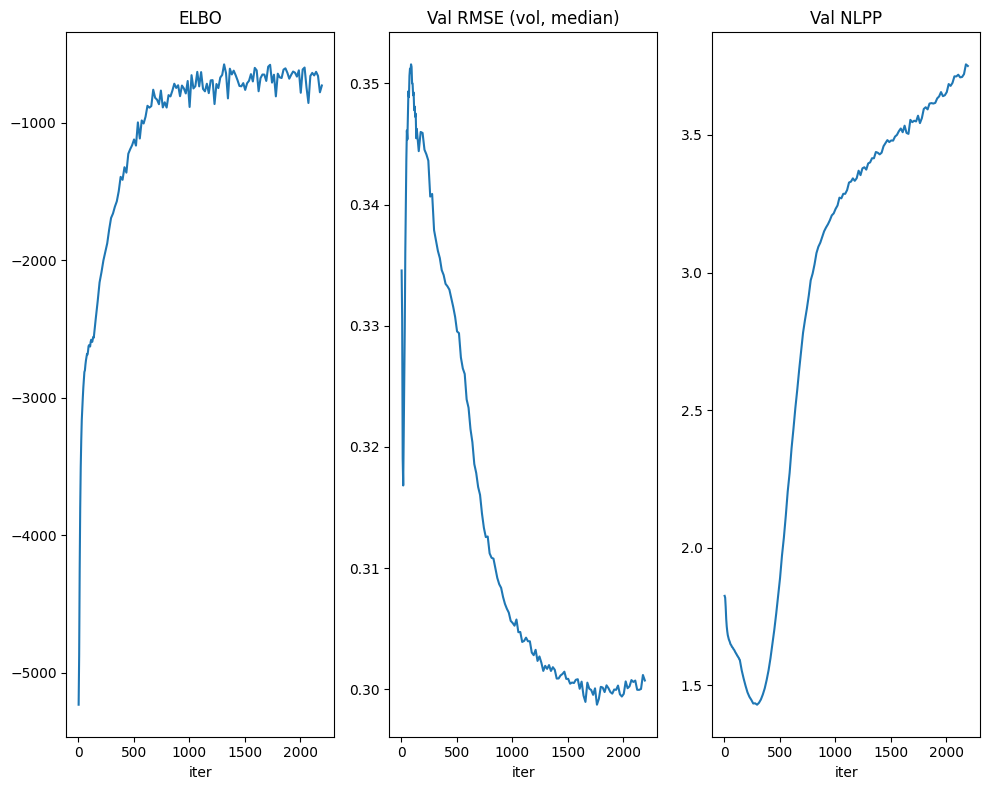

In [ ]:
# Training curves 
times, elbos, v1, v2 = [], [], [], []
for k, v in hist.items():
    if str(k).isdigit():
        times.append(v.get('time', np.nan))
        elbos.append(v.get('elbo', np.nan))
        if 'val' in v:
            v1.append(v['val'][0])
            v2.append(v['val'][1])

fig, ax = plt.subplots(1, 3, figsize=(10, 8))
ax[0].plot(times, elbos);                 ax[0].set_title("ELBO"); ax[0].set_xlabel("iter")
if v1: ax[1].plot(times[:len(v1)], v1);   ax[1].set_title("Val RMSE (vol, median)"); ax[1].set_xlabel("iter")
if v2: ax[2].plot(times[:len(v2)], v2);   ax[2].set_title("Val NLPP"); ax[2].set_xlabel("iter")
plt.tight_layout(); plt.show()


[train]  RMSE_log: 0.063171   MAE_log: 0.048650
[valid]  RMSE_log: 0.300721   MAE_log: 0.253299
[test]  RMSE_log: 0.273062   MAE_log: 0.240675


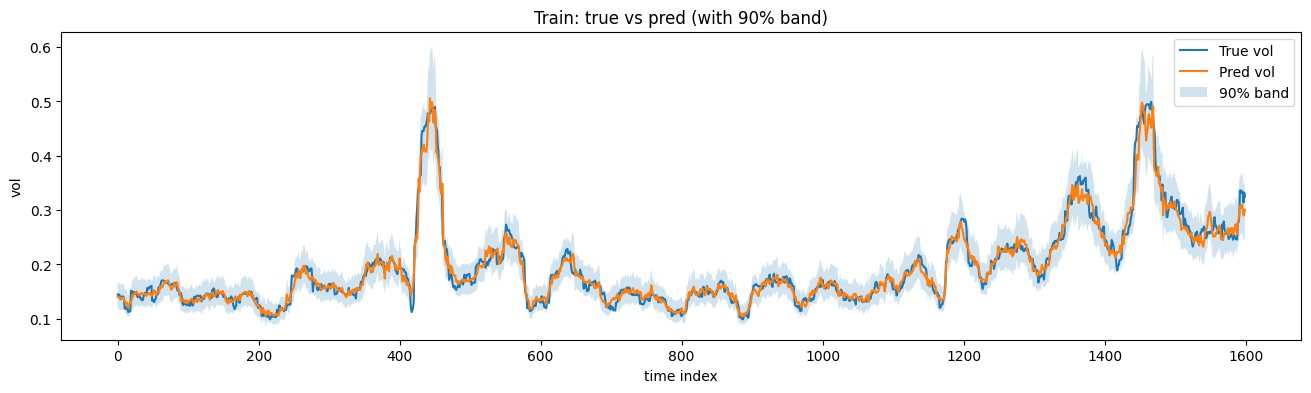

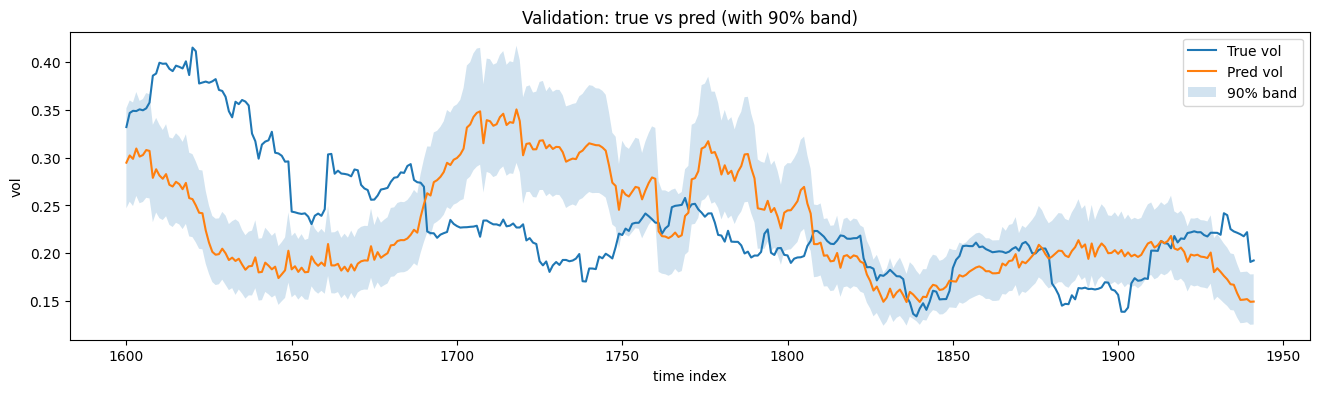

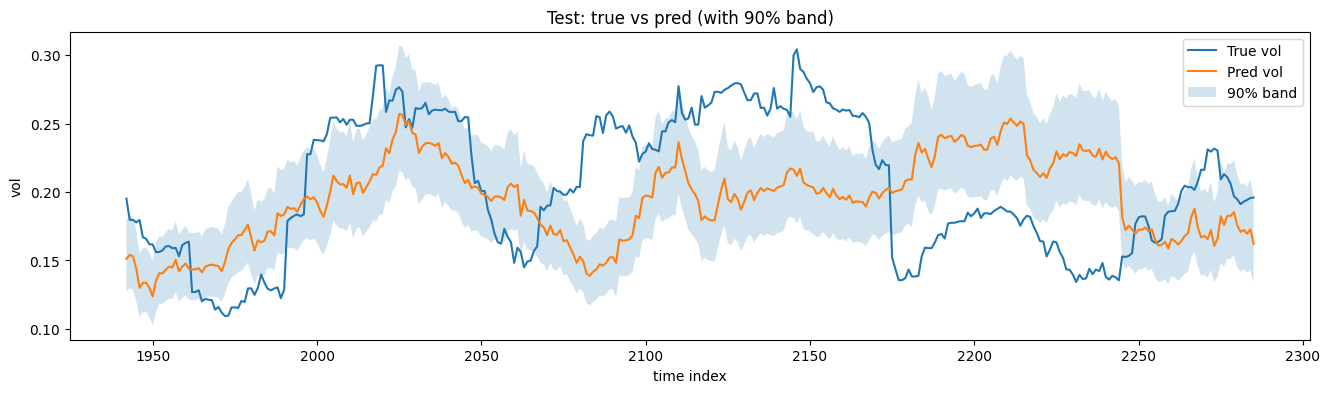

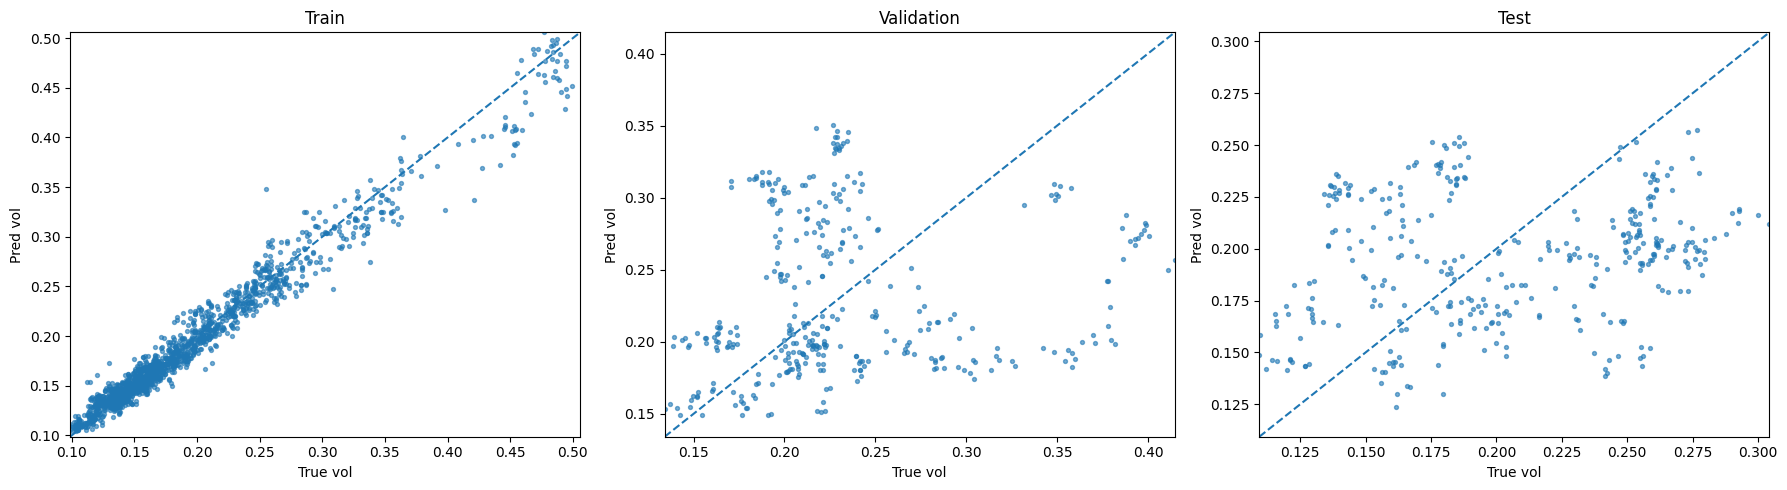

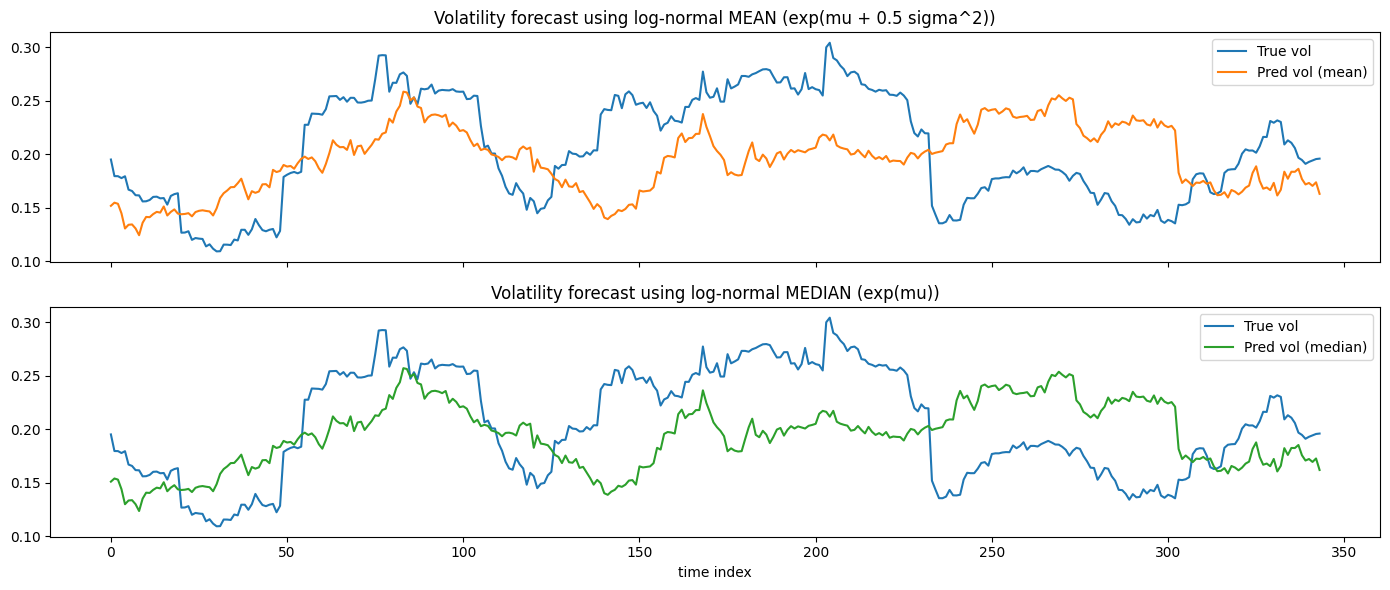

In [ ]:
# Evaluation & plots 
from scipy.stats import norm

PRED_CHUNK = 128  

def _pred_scaled_batched(m, X_seq, chunk=PRED_CHUNK):
    N = len(X_seq)
    mu_parts, var_parts = [], []
    noise = float(m.likelihood.variance.numpy())
    for i in range(0, N, chunk):
        xb = tf.convert_to_tensor(X_seq[i:i+chunk], dtype=tf_float)
        f_mu, f_var = m.predict_f(xb)                
        y_mu  = tf.reshape(f_mu,  [-1]).numpy()
        y_var = tf.reshape(f_var, [-1]).numpy() + noise
        y_var = np.maximum(y_var, 1e-12)
        mu_parts.append(y_mu); var_parts.append(y_var)
    return np.concatenate(mu_parts), np.concatenate(var_parts)

def _unscale_log(mu_scaled, var_scaled):
    mu_log  = scaler_y.inverse_transform(mu_scaled.reshape(-1,1)).ravel()
    var_log = np.maximum(var_scaled, 0.0) * (scaler_y.scale_[0]**2)
    return mu_log, var_log

def evaluate_split_log(name, X_seq, y_scaled, *, use_median=False):
    """
    Prints RMSE/MAE in log units. Also returns both log- and vol-scale
    quantities for plotting:
      - mu_log, var_log, true_log
      - pred_vol_mean (mean of lognormal) or pred_vol_median (median)
      - true_vol
      - q05_vol, q95_vol (90% band on vol)
    """
    # predictions in scaled log space
    y_mu_s, y_var_s = _pred_scaled_batched(model, X_seq)
    mu_log, var_log = _unscale_log(y_mu_s, y_var_s)
    true_log = scaler_y.inverse_transform(y_scaled.reshape(-1,1)).ravel()

    # LOG-scale metrics
    rmse_log = float(np.sqrt(np.mean((mu_log - true_log)**2)))
    mae_log  = float(np.mean(np.abs(mu_log - true_log)))
    print(f"[{name}]  RMSE_log: {rmse_log:.6f}   MAE_log: {mae_log:.6f}")

    # Convert to VOL scale for plots
    s_log = np.sqrt(var_log)
    true_vol = np.exp(true_log)

    if use_median:
        pred_vol = np.exp(mu_log)                 
    else:
        pred_vol = np.exp(mu_log + 0.5*var_log)    

    q05_vol = np.exp(mu_log + norm.ppf(0.05) * s_log)
    q95_vol = np.exp(mu_log + norm.ppf(0.95) * s_log)

    return {
        "mu_log": mu_log, "var_log": var_log, "true_log": true_log,
        "pred_vol": pred_vol, "true_vol": true_vol,
        "q05_vol": q05_vol, "q95_vol": q95_vol,
    }

res_tr = evaluate_split_log("train", X_tr, y_tr, use_median=True)
res_va = evaluate_split_log("valid", X_va, y_va, use_median=True)
res_te = evaluate_split_log("test",  X_te, y_te, use_median=True)

def ts_with_band(idx_start, res, title):
    pv = res["pred_vol"]; tv = res["true_vol"]
    q05, q95 = res["q05_vol"], res["q95_vol"]
    t = np.arange(idx_start, idx_start + len(pv))
    plt.figure(figsize=(16,4))
    plt.plot(t, tv, label="True vol")
    plt.plot(t, pv, label="Pred vol")
    plt.fill_between(t, q05, q95, alpha=0.2, label="90% band")
    plt.title(title); plt.legend(); plt.xlabel("time index"); plt.ylabel("vol"); plt.show()

# Time-series with bands
n_tr = len(res_tr["pred_vol"])
n_va = len(res_va["pred_vol"]) if res_va is not None else 0
n_te = len(res_te["pred_vol"])

ts_with_band(0,           res_tr, "Train: true vs pred (with 90% band)")
ts_with_band(n_tr,        res_va, "Validation: true vs pred (with 90% band)")
ts_with_band(n_tr + n_va, res_te, "Test: true vs pred (with 90% band)")

# Scatter plots (vol scale)
def scatter_split(ax, res, title):
    pv, tv = res["pred_vol"], res["true_vol"]
    lo = min(pv.min(), tv.min()); hi = max(pv.max(), tv.max())
    ax.scatter(tv, pv, s=8, alpha=0.6)
    ax.plot([lo,hi],[lo,hi], linestyle="--")
    ax.set_title(title); ax.set_xlabel("True vol"); ax.set_ylabel("Pred vol")
    ax.set_xlim(lo, hi); ax.set_ylim(lo, hi)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
scatter_split(ax[0], res_tr, "Train"); scatter_split(ax[1], res_va, "Validation"); scatter_split(ax[2], res_te, "Test")
plt.tight_layout(); plt.show()


import matplotlib.pyplot as plt
import numpy as np

# Predict in scaled log-space
y_mu_s, y_var_s = _pred_scaled_batched(model, X_te)

# Unscale to original log-vol space
mu_log, var_log = _unscale_log(y_mu_s, y_var_s)  
true_log = scaler_y.inverse_transform(y_te.reshape(-1,1)).ravel()

pred_vol_mean   = np.exp(mu_log + 0.5 * var_log)   
pred_vol_median = np.exp(mu_log)                   
true_vol        = np.exp(true_log)

# Plot
fig, ax = plt.subplots(2, 1, figsize=(14,6), sharex=True)

ax[0].plot(true_vol, label="True vol", color="C0")
ax[0].plot(pred_vol_mean, label="Pred vol (mean)", color="C1")
ax[0].set_title("Volatility forecast using log-normal MEAN (exp(mu + 0.5 sigma^2))")
ax[0].legend()

ax[1].plot(true_vol, label="True vol", color="C0")
ax[1].plot(pred_vol_median, label="Pred vol (median)", color="C2")
ax[1].set_title("Volatility forecast using log-normal MEDIAN (exp(mu))")
ax[1].legend()

plt.xlabel("time index")
plt.tight_layout()
plt.show()


[train]  MSE_log: 0.003991   MAE_log: 0.048650
[valid]  MSE_log: 0.090433   MAE_log: 0.253299
[test]  MSE_log: 0.074563   MAE_log: 0.240675


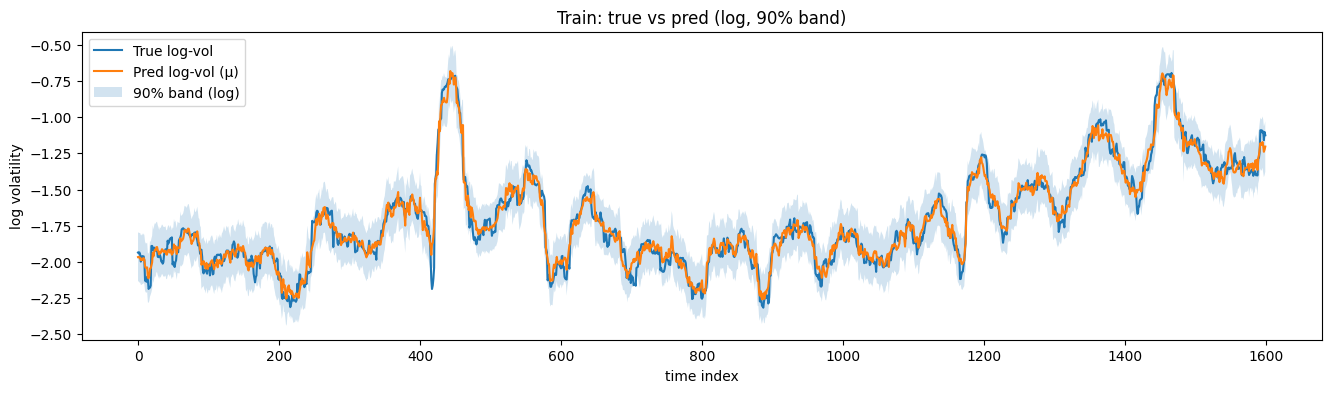

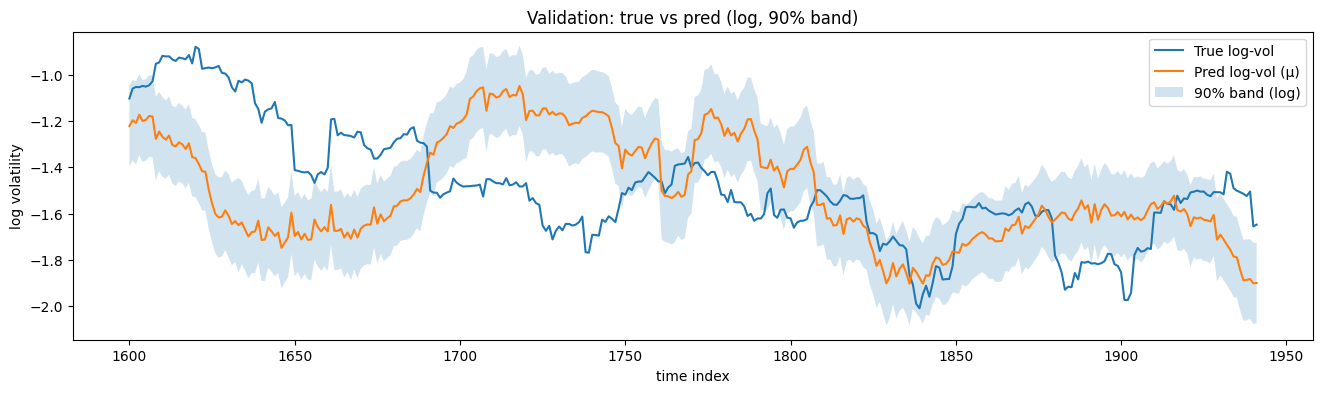

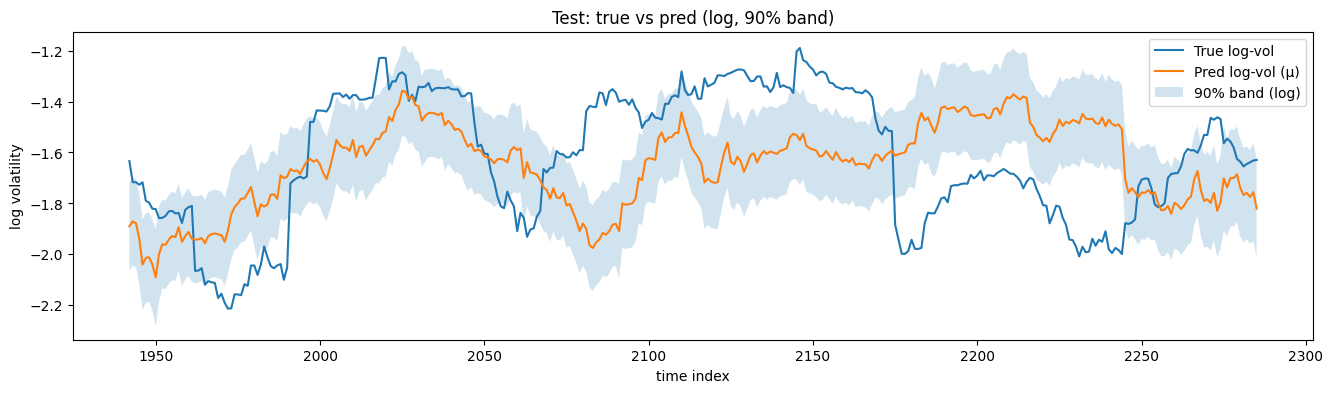

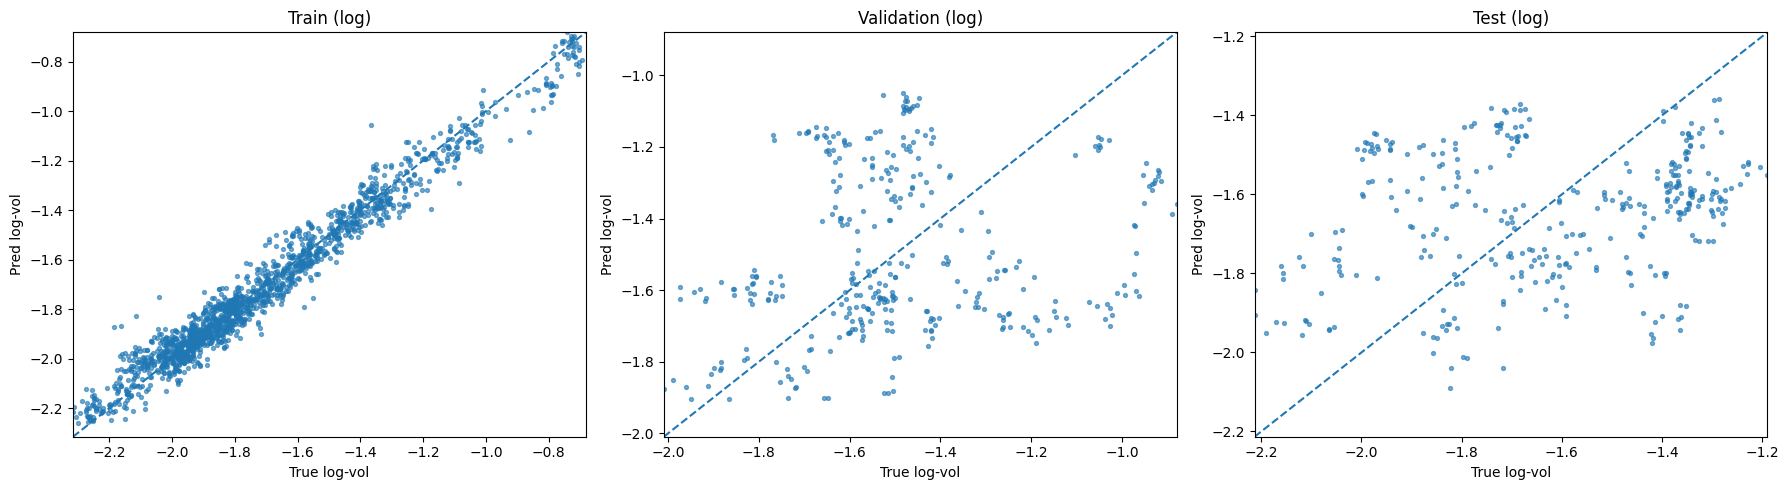

In [ ]:
# metrics and calibration
import os, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import norm

os.makedirs("plots", exist_ok=True)

def interval_score(alpha, l, u, y):
    width = u - l
    under = (l - y) if y < l else 0.0
    over  = (y - u) if y > u else 0.0
    return width + (2.0/alpha)*under + (2.0/alpha)*over

def crps_gaussian(y, mu, sig):
    z   = (y - mu) / np.maximum(sig, 1e-12)
    pdf = norm.pdf(z); cdf = norm.cdf(z)
    return sig * (z * (2*cdf - 1) + 2*pdf - 1/np.sqrt(np.pi))

def summarize_split(name, res, alpha=0.10, save_prefix="siggp"):
    mu  = res["mu_log"]
    tl  = res["true_log"]
    s   = np.sqrt(res["var_log"])
    lo  = mu + norm.ppf(alpha/2) * s
    hi  = mu + norm.ppf(1 - alpha/2) * s

    # point metrics
    mae = float(mean_absolute_error(tl, mu))
    mse = float(mean_squared_error(tl, mu))

    # interval metrics
    cov = float(np.mean((tl >= lo) & (tl <= hi)))
    wid = float(np.mean(hi - lo))
    isv = float(np.mean([interval_score(alpha, lo[i], hi[i], tl[i]) for i in range(len(tl))]))

    # CRPS (Gaussian closed-form)
    crp = float(np.mean(crps_gaussian(tl, mu, s)))

    print(f"[{name}] MAE={mae:.6f}  MSE={mse:.6f}  Cov90={cov:.3f}  "
          f"Width90={wid:.6f}  IS90={isv:.6f}  CRPS={crp:.6f}")

    #  PIT histogram 
    pit = norm.cdf((tl - mu) / np.maximum(s, 1e-12))
    plt.figure(figsize=(6,4))
    plt.hist(pit, bins=20, range=(0,1), density=True, edgecolor="k")
    plt.axhline(1.0, color="r", linestyle="--", linewidth=1.0)
    plt.title(f"PIT histogram ({name}, log scale)")
    plt.tight_layout()
    plt.savefig(f"plots/gp2/{save_prefix}_{name.lower()}_pit.png", dpi=160); plt.show()

    #  Reliability: quantiles 
    qgrid = np.array([0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95])
    emp   = []
    for p in qgrid:
        q = mu + norm.ppf(p) * s
        emp.append(np.mean(tl <= q))
    emp = np.array(emp)

    xx = np.linspace(0,1,201)
    plt.figure(figsize=(5.5,5.5))
    plt.plot(xx, xx, "--", lw=1.0, label="Ideal")
    plt.plot(qgrid, emp, "o-", lw=1.5, label="Empirical")
    plt.xlabel("Nominal quantile level p"); plt.ylabel(r"Empirical $P(Y <= q_p)$")
    plt.title(f"Reliability — quantiles ({name}, log)")
    plt.legend(); plt.tight_layout()
    plt.savefig(f"plots/gp2/{save_prefix}_{name.lower()}_reliab_quant.png", dpi=160); plt.show()

    #  Reliability: central intervals
    cgrid = np.array([0.50, 0.60, 0.70, 0.80, 0.90, 0.95])
    emp_c = []
    for c in cgrid:
        a = (1-c)/2.0; b = 1 - a
        lo_c = mu + norm.ppf(a) * s
        hi_c = mu + norm.ppf(b) * s
        emp_c.append(np.mean((tl >= lo_c) & (tl <= hi_c)))
    emp_c = np.array(emp_c)

    plt.figure(figsize=(5.5,5.5))
    plt.plot(xx, xx, "--", lw=1.0, label="Ideal")
    plt.plot(cgrid, emp_c, "s-", lw=1.5, label="Empirical")
    plt.xlabel("Nominal central coverage"); plt.ylabel("Empirical coverage")
    plt.title(f"Reliability — central intervals ({name}, log)")
    plt.legend(); plt.tight_layout()
    plt.savefig(f"plots/gp2/{save_prefix}_{name.lower()}_reliab_central.png", dpi=160); plt.show()

    #  Rolling coverage 
    win = 100
    covered = ((tl >= lo) & (tl <= hi)).astype(float)
    if len(covered) >= win:
        roll = np.convolve(covered, np.ones(win)/win, mode="valid")
        plt.figure(figsize=(12,3.5))
        plt.plot(roll, lw=1.3, label=f"Rolling coverage ({win})")
        plt.axhline(0.90, ls="--", lw=1.0, label="Nominal 90%")
        plt.ylim(0,1.05)
        plt.title(f"Rolling coverage of 90% intervals ({name}, log)")
        plt.legend(); plt.tight_layout()
        plt.savefig(f"plots/gp2/{save_prefix}_{name.lower()}_rolling_cov.png", dpi=160); plt.show()

    return {"MAE": mae, "MSE": mse, "Coverage90": cov, "Width90": wid, "IS90": isv, "CRPS": crp}

metrics_te = summarize_split("test",  res_te, alpha=0.10, save_prefix="siggp")

import pandas as pd
pd.DataFrame([{"Model":"Signature GP (test)",
               **metrics_te}]).to_csv("plots/siggp_test_metrics_log.csv", index=False)
print("[Saved] plots/siggp_test_metrics_log.csv")


[test] MAE=0.240675  MSE=0.074563  Cov90=0.349  Width90=0.349402  IS90=2.156093  CRPS=0.189418


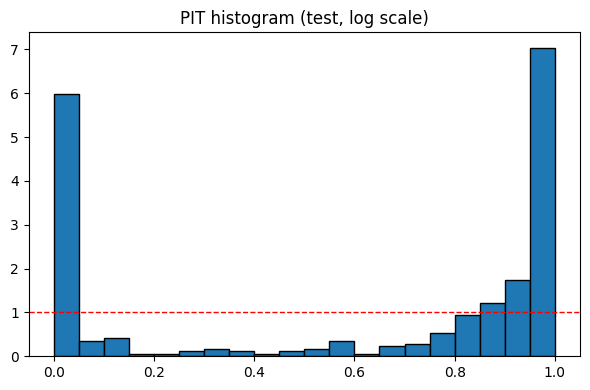

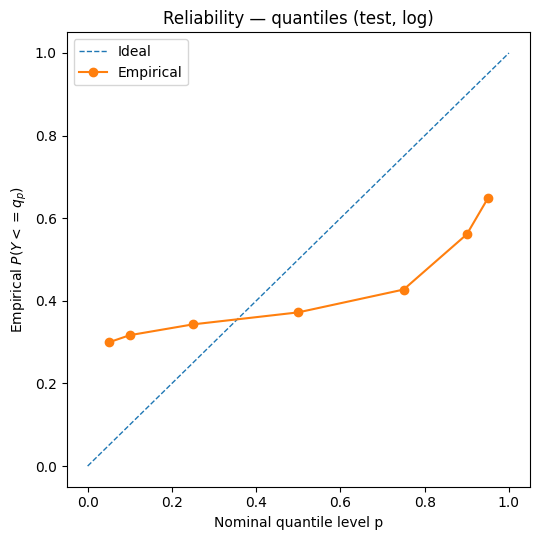

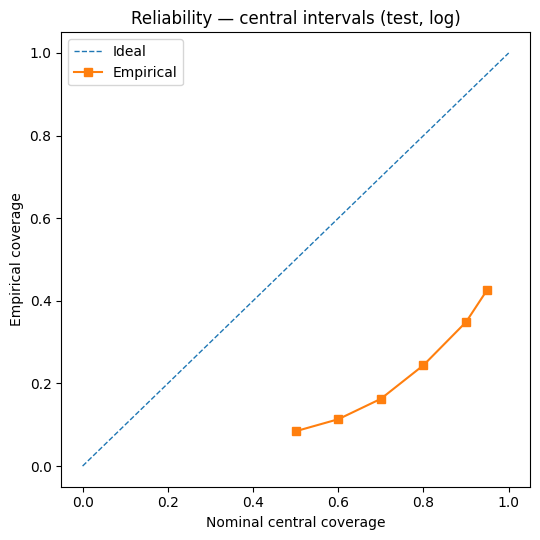

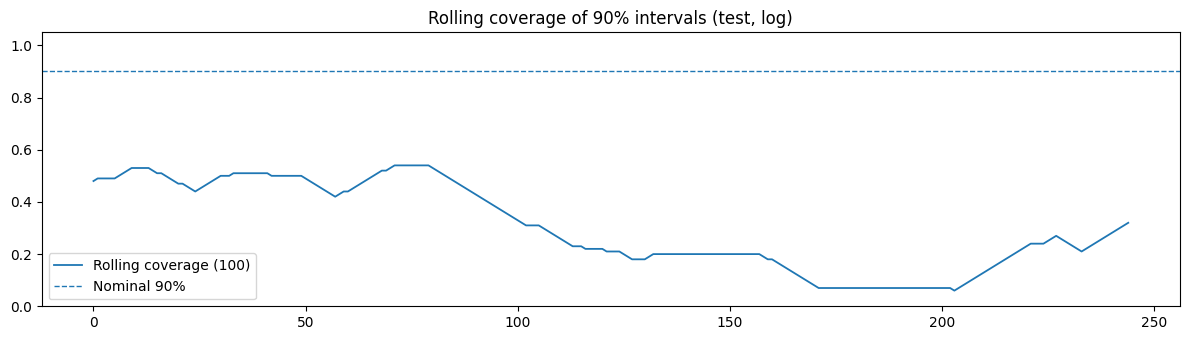

[Saved] plots/siggp_test_metrics_log.csv


In [ ]:
# metrics and calibration
import os, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import norm

os.makedirs("plots", exist_ok=True)

def interval_score(alpha, l, u, y):
    width = u - l
    under = (l - y) if y < l else 0.0
    over  = (y - u) if y > u else 0.0
    return width + (2.0/alpha)*under + (2.0/alpha)*over

def crps_gaussian(y, mu, sig):
    z   = (y - mu) / np.maximum(sig, 1e-12)
    pdf = norm.pdf(z); cdf = norm.cdf(z)
    return sig * (z * (2*cdf - 1) + 2*pdf - 1/np.sqrt(np.pi))

def summarize_split(name, res, alpha=0.10, save_prefix="siggp"):
    mu  = res["mu_log"]
    tl  = res["true_log"]
    s   = np.sqrt(res["var_log"])
    lo  = mu + norm.ppf(alpha/2) * s
    hi  = mu + norm.ppf(1 - alpha/2) * s

    # point metrics
    mae = float(mean_absolute_error(tl, mu))
    mse = float(mean_squared_error(tl, mu))

    # interval metrics
    cov = float(np.mean((tl >= lo) & (tl <= hi)))
    wid = float(np.mean(hi - lo))
    isv = float(np.mean([interval_score(alpha, lo[i], hi[i], tl[i]) for i in range(len(tl))]))

    # CRPS (Gaussian closed-form)
    crp = float(np.mean(crps_gaussian(tl, mu, s)))

    print(f"[{name}] MAE={mae:.6f}  MSE={mse:.6f}  Cov90={cov:.3f}  "
          f"Width90={wid:.6f}  IS90={isv:.6f}  CRPS={crp:.6f}")

    #  PIT histogram 
    pit = norm.cdf((tl - mu) / np.maximum(s, 1e-12))
    plt.figure(figsize=(6,4))
    plt.hist(pit, bins=20, range=(0,1), density=True, edgecolor="k")
    plt.axhline(1.0, color="r", linestyle="--", linewidth=1.0)
    plt.title(f"PIT histogram ({name}, log scale)")
    plt.tight_layout()
    plt.savefig(f"plots/gp2/{save_prefix}_{name.lower()}_pit.png", dpi=160); plt.show()

    #  Reliability: quantiles 
    qgrid = np.array([0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95])
    emp   = []
    for p in qgrid:
        q = mu + norm.ppf(p) * s
        emp.append(np.mean(tl <= q))
    emp = np.array(emp)

    xx = np.linspace(0,1,201)
    plt.figure(figsize=(5.5,5.5))
    plt.plot(xx, xx, "--", lw=1.0, label="Ideal")
    plt.plot(qgrid, emp, "o-", lw=1.5, label="Empirical")
    plt.xlabel("Nominal quantile level p"); plt.ylabel(r"Empirical $P(Y <= q_p)$")
    plt.title(f"Reliability — quantiles ({name}, log)")
    plt.legend(); plt.tight_layout()
    plt.savefig(f"plots/gp2/{save_prefix}_{name.lower()}_reliab_quant.png", dpi=160); plt.show()

    #  Reliability: central intervals
    cgrid = np.array([0.50, 0.60, 0.70, 0.80, 0.90, 0.95])
    emp_c = []
    for c in cgrid:
        a = (1-c)/2.0; b = 1 - a
        lo_c = mu + norm.ppf(a) * s
        hi_c = mu + norm.ppf(b) * s
        emp_c.append(np.mean((tl >= lo_c) & (tl <= hi_c)))
    emp_c = np.array(emp_c)

    plt.figure(figsize=(5.5,5.5))
    plt.plot(xx, xx, "--", lw=1.0, label="Ideal")
    plt.plot(cgrid, emp_c, "s-", lw=1.5, label="Empirical")
    plt.xlabel("Nominal central coverage"); plt.ylabel("Empirical coverage")
    plt.title(f"Reliability — central intervals ({name}, log)")
    plt.legend(); plt.tight_layout()
    plt.savefig(f"plots/gp2/{save_prefix}_{name.lower()}_reliab_central.png", dpi=160); plt.show()

    #  Rolling coverage 
    win = 100
    covered = ((tl >= lo) & (tl <= hi)).astype(float)
    if len(covered) >= win:
        roll = np.convolve(covered, np.ones(win)/win, mode="valid")
        plt.figure(figsize=(12,3.5))
        plt.plot(roll, lw=1.3, label=f"Rolling coverage ({win})")
        plt.axhline(0.90, ls="--", lw=1.0, label="Nominal 90%")
        plt.ylim(0,1.05)
        plt.title(f"Rolling coverage of 90% intervals ({name}, log)")
        plt.legend(); plt.tight_layout()
        plt.savefig(f"plots/gp2/{save_prefix}_{name.lower()}_rolling_cov.png", dpi=160); plt.show()

    return {"MAE": mae, "MSE": mse, "Coverage90": cov, "Width90": wid, "IS90": isv, "CRPS": crp}

metrics_te = summarize_split("test",  res_te, alpha=0.10, save_prefix="siggp")

import pandas as pd
pd.DataFrame([{"Model":"Signature GP (test)",
               **metrics_te}]).to_csv("plots/siggp_test_metrics_log.csv", index=False)
print("[Saved] plots/siggp_test_metrics_log.csv")


[ACI] q̂_(1-α) from validation: 4.657
[SigGP + ACI lag 30] MSE(log)=0.074563  Coverage=0.875  Width=0.829821  Interval Score 90=1.173717


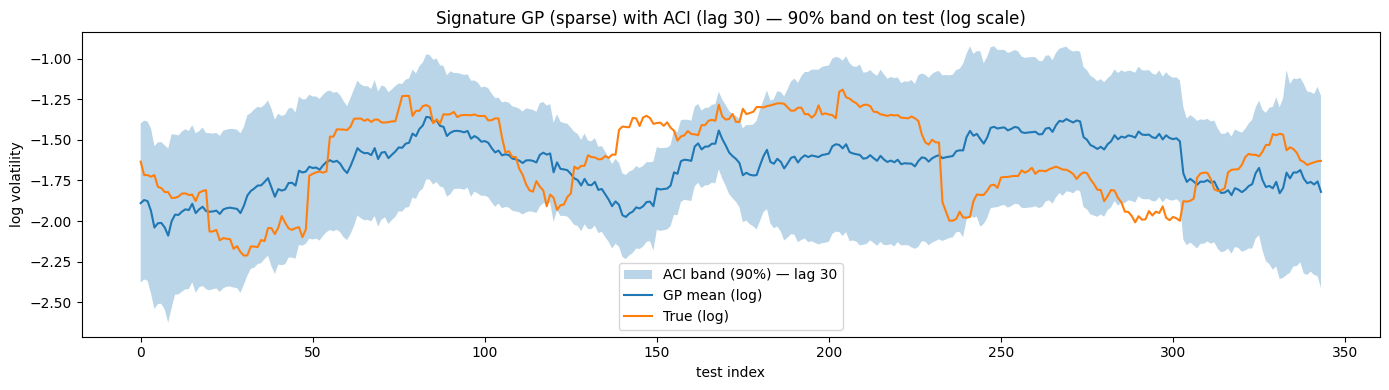

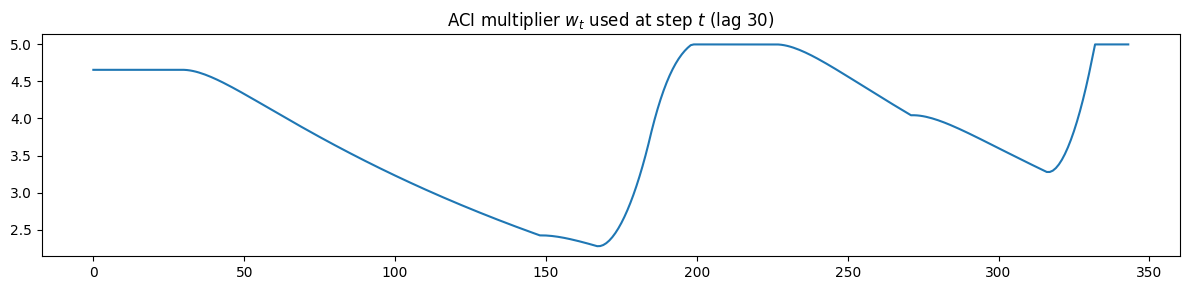

In [ ]:
#  ACI (90%) for Signature GP
import os, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

os.makedirs("plots/siggp", exist_ok=True)

# Config
alpha  = 0.10     # 90% central interval
H      = 30       # horizon
beta   = 0.90     # EMA smoothing for misses
k_gain = 0.06     # multiplicative gain
w_min  = 0.05     # anti-windup lower
w_max  = 5.0      # anti-windup upper
sd_floor = 1e-8   # protects against tiny std on log scale

def gp_mu_sd_log_batch(model, X_seq, chunk=128):
    """Return mu_log, sd_log arrays for a whole split."""
    mu_s, var_s = _pred_scaled_batched(model, X_seq, chunk=chunk)  
    mu_log, var_log = _unscale_log(mu_s, var_s)                    
    sd_log = np.sqrt(np.maximum(var_log, 0.0))
    return mu_log, sd_log

mu_va_log, sd_va_log = gp_mu_sd_log_batch(model, X_va, chunk=PRED_CHUNK)
y_va_log = scaler_y.inverse_transform(y_va.reshape(-1,1)).ravel()

scores = np.abs(y_va_log - mu_va_log) / np.maximum(sd_va_log, sd_floor)
scores = scores[np.isfinite(scores)]
w0 = float(np.quantile(scores, 1 - alpha)) if scores.size else 1.0
print(f"[ACI] q̂_(1-α) from validation: {w0:.3f}")

mu_te_log, sd_te_log = gp_mu_sd_log_batch(model, X_te, chunk=PRED_CHUNK)
y_te_log = scaler_y.inverse_transform(y_te.reshape(-1,1)).ravel()

n_te = len(y_te_log)
mu_arr = np.full(n_te, np.nan)
sd_arr = np.full(n_te, np.nan)
lo_arr = np.full(n_te, np.nan)
hi_arr = np.full(n_te, np.nan)
w_used = np.full(n_te, np.nan)

w = float(np.clip(w0, w_min, w_max))
miss_ema = alpha  # neutral start

#  Online ACI with horizon-lagged updates 
for i in range(n_te):
    mu_i = float(mu_te_log[i])
    sd_i = float(max(sd_te_log[i], sd_floor))

    mu_arr[i] = mu_i
    sd_arr[i] = sd_i
    lo_arr[i] = mu_i - w * sd_i
    hi_arr[i] = mu_i + w * sd_i
    w_used[i] = w

    j = i - H  
    if j >= 0 and np.isfinite(y_te_log[j]) and np.isfinite(lo_arr[j]) and np.isfinite(hi_arr[j]):
        miss = 0.0 if (lo_arr[j] <= y_te_log[j] <= hi_arr[j]) else 1.0
        miss_ema = beta * miss_ema + (1 - beta) * miss
        w = float(np.clip(w * np.exp(k_gain * (miss_ema - alpha)), w_min, w_max))

#  Metrics
mask = np.isfinite(mu_arr) & np.isfinite(lo_arr) & np.isfinite(hi_arr) & np.isfinite(y_te_log)
y_eff  = y_te_log[mask]
mu_eff = mu_arr[mask]
lo_eff = lo_arr[mask]
hi_eff = hi_arr[mask]

def interval_score(alpha, l, u, y):
    width = u - l
    return width + (2.0/alpha)*np.maximum(l - y, 0.0) + (2.0/alpha)*np.maximum(y - u, 0.0)

cov  = float(np.mean((y_eff >= lo_eff) & (y_eff <= hi_eff)))
wid  = float(np.mean(hi_eff - lo_eff))
mse  = float(mean_squared_error(y_eff, mu_eff))
is90 = float(np.mean([interval_score(alpha, lo_eff[t], hi_eff[t], y_eff[t]) for t in range(len(y_eff))]))

print(f"[SigGP + ACI lag {H}] MSE(log)={mse:.6f}  Coverage={cov:.3f}  Width={wid:.6f}  Interval Score 90={is90:.6f}")

# Plot
x = np.arange(n_te)
plt.figure(figsize=(14,4))
plt.fill_between(x, lo_arr, hi_arr, alpha=.30, label=f'ACI band (90%) — lag {H}')
plt.plot(mu_arr, label='GP mean (log)'); plt.plot(y_te_log, label='True (log)')
plt.title(f'Signature GP (sparse) with ACI (lag {H}) — 90% band on test (log scale)')
plt.xlabel('test index'); plt.ylabel('log volatility'); plt.legend()
plt.tight_layout()
plt.savefig("plots/gp2/siggp_aci_test_band_log.png", dpi=160)
plt.show()

plt.figure(figsize=(12,3.0))
plt.plot(w_used)
plt.title(f'ACI multiplier $w_t$ used at step $t$ (lag {H})')
plt.tight_layout(); plt.show()


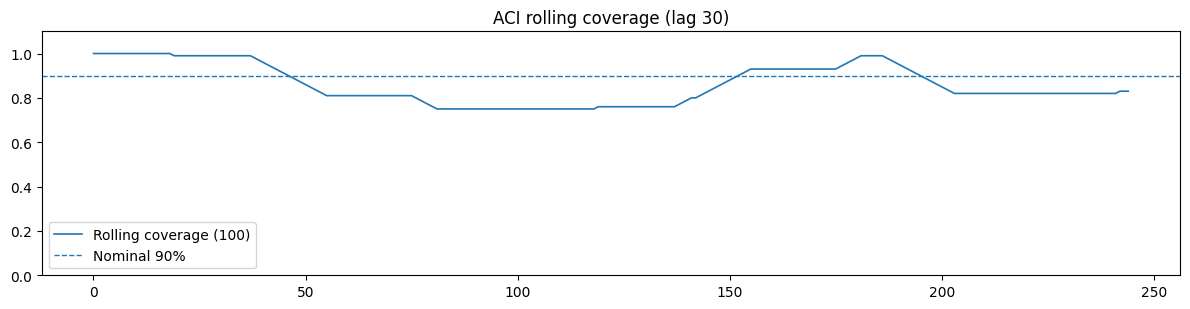

w0 (from val): 4.657
w_used mean:   3.902  median: 4.008  last: 5.000
[Saved] plots/gp2/siggp_aci_test_metrics_log.csv


In [ ]:
# Rolling coverage of the ACI band 
import numpy as np, matplotlib.pyplot as plt, os, pandas as pd

os.makedirs("plots/gp2", exist_ok=True)

win = 100
covered = ((y_eff >= lo_eff) & (y_eff <= hi_eff)).astype(float)
if len(covered) >= win:
    roll = np.convolve(covered, np.ones(win)/win, mode="valid")
    plt.figure(figsize=(12,3.2))
    plt.plot(roll, lw=1.2, label=f"Rolling coverage ({win})")
    plt.axhline(0.90, ls="--", lw=1.0, label="Nominal 90%")
    plt.ylim(0, 1.1)
    plt.legend()
    plt.title("ACI rolling coverage (lag 30)")
    plt.tight_layout()
    plt.savefig("plots/gp2/siggp_aci_coverage_by_time.png", dpi=160)
    plt.show()
else:
    print(f"[ACI] Not enough points for rolling window (need ≥ {win}, have {len(covered)}).")

print(f"w0 (from val): {w0:.3f}")
print(f"w_used mean:   {np.nanmean(w_used):.3f}  median: {np.nanmedian(w_used):.3f}  last: {w_used[~np.isnan(w_used)][-1]:.3f}")

row = {
    "Model": "SigGP + ACI (lag 30)",
    "H": 30, "beta": 0.9, "k": 0.06, "w0": float(w0),
    "MSE_log": float(mse), "Coverage90": float(cov),
    "AvgWidth90": float(wid), "IntervalScore90": float(is90),
}
pd.DataFrame([row]).to_csv("plots/gp2/siggp_aci_test_metrics_log.csv", index=False)
print("[Saved] plots/gp2/siggp_aci_test_metrics_log.csv")
